## 1.准备阶段
训练数据集 `train_set` 以及测试数据集 `test_set`  
创建 `train_loader` 和 `test_loader` 用于训练以及测试过程的数据加载

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torchvision
import torchvision.transforms as transforms
import torch

print("CUDA Device Count:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i} Name:", torch.cuda.get_device_name(i))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"正在使用的是: {device}")

# 创建一个transform, 将 PIL 图片转换为 Tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# 下载并加载 CIFAR-10 训练集
# root: 数据集存放路径 (如果路径不存在会自动创建)
# train=True: 指明要加载训练集
# download=True: 如果本地没有, 会自动从网络下载
# transform=transform: 对每张图片应用上面定义的 transform (即 ToTensor)
CIFAR10_trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 同理, 下载并加载 CIFAR-10 测试集
# train=False: 指明要加载测试集
CIFAR10_testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

def get_stats(Data_set):
    # 此函数用于计算给定数据集 (Data_set) 中所有图像的通道均值和标准差
    # Data_set 中的每个元素是一个二元组 (image_tensor, label)
    # 其中 image_tensor 的形状为 [C, H, W], label 是该图像对应的类别标签

    # 通过列表推导式, 将数据集中所有样本的图像 Tensor 提取出来
    # item[0] 是图像 Tensor, item[1] 是标签, 故只取 item[0]
    imgs = [item[0] for item in Data_set]

    # torch.stack 会沿着维度 (dim=0) 将列表中的 Tensor 连接成一个更高维度的 Tensor
    # 假设 Data_set 中有 N 张图像, 每张图像的 Tensor 形状是 [3, 32, 32]
    # 那么执行 torch.stack(imgs, dim=0) 后得到的 Tensor 形状就是 [N, 3, 32, 32]
    imgs = torch.stack(imgs, dim=0)

    # 计算每个通道的均值和标准差
    means = imgs.mean(dim=(0, 2, 3))
    stds  = imgs.std(dim=(0, 2, 3))

    return means, stds

# 调用 get_stats 计算训练集的通道均值和标准差
CIFAR_MEAN_TRAIN, CIFAR_STD_TRAIN = get_stats(CIFAR10_trainset)
print(f"CIFAR Train Set Mean: {CIFAR_MEAN_TRAIN[0]:.4f}, {CIFAR_MEAN_TRAIN[1]:.4f}, {CIFAR_MEAN_TRAIN[2]:.4f}")
print(f"CIFAR Train Set Std: {CIFAR_STD_TRAIN[0]:.4f}, {CIFAR_STD_TRAIN[1]:.4f}, {CIFAR_STD_TRAIN[2]:.4f}")

# 调用 get_stats 计算测试集的通道均值和标准差
CIFAR_MEAN_TEST, CIFAR_STD_TEST = get_stats(CIFAR10_testset)
print(f"CIFAR Test Set Mean: {CIFAR_MEAN_TEST[0]:.4f}, {CIFAR_MEAN_TEST[1]:.4f}, {CIFAR_MEAN_TEST[2]:.4f}")
print(f"CIFAR Test Set Std: {CIFAR_STD_TEST[0]:.4f}, {CIFAR_STD_TEST[1]:.4f}, {CIFAR_STD_TEST[2]:.4f}")

CUDA Device Count: 1
Device 0 Name: NVIDIA RTX A6000
正在使用的是: cuda
CIFAR Train Set Mean: 0.4914, 0.4822, 0.4465
CIFAR Train Set Std: 0.2470, 0.2435, 0.2616
CIFAR Test Set Mean: 0.4942, 0.4851, 0.4504
CIFAR Test Set Std: 0.2467, 0.2429, 0.2616


In [2]:
import numpy as np
import random
from torch.utils.data import ConcatDataset

# Set seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
     torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data transforms (normalization & data augmentation)
STATS_TRAIN = (CIFAR_MEAN_TRAIN, CIFAR_STD_TRAIN)
STATS_TEST = (CIFAR_MEAN_TEST, CIFAR_STD_TEST)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(*STATS_TRAIN),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*STATS_TEST)
])

# PyTorch datasets
train_set = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=train_transform
)
test_set = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=test_transform
)

classes = train_set.classes
print(classes)

# PyTorch data loaders
def to_device(batch, device):
    # Moving tensors to the default device
    if isinstance(batch, (list,tuple)):
        return [to_device(x, device) for x in batch]
    return batch.to(device, non_blocking=True)

class DeviceDataLoader():
    # Wrap a dataloader in order to transfer data to a device
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        # generating a batch of data after transferring data to the device
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        # batches size
        return len(self.dataloader)

    def __getattr__(self, name):
        # 如果有人写 train_loader.batch_size, 就可以直接返回底层 dataloader.batch_size
        return getattr(self.dataloader, name)

batch_size = 256
train_set_doubled = ConcatDataset([train_set, train_set])
train_loader = torch.utils.data.DataLoader(
    train_set_doubled, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True, # 异步复制
    num_workers=2
)
train_loader = DeviceDataLoader(train_loader, device)

test_loader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=batch_size*2, 
    shuffle=False, 
    pin_memory=True, # 异步复制
    num_workers=2
)
test_loader = DeviceDataLoader(test_loader, device)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


显示一些训练图像:


/tmp/ipykernel_1318437/1117437391.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  imgs = imgs * np.array(stds)[None, None, :] + np.array(means)[None, None, :]


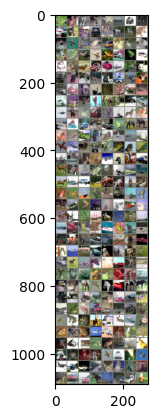

Labels: frog  cat   cat   deer  cat   ship  automobile bird  ship  dog   airplane automobile dog   deer  horse frog  frog  airplane deer  frog  automobile cat   dog   ship  dog   frog  automobile bird  frog  automobile frog  automobile cat   dog   deer  automobile automobile ship  frog  cat   automobile cat   cat   deer  dog   truck deer  deer  automobile automobile dog   bird  frog  bird  cat   deer  automobile ship  cat   bird  dog   cat   dog   automobile airplane deer  cat   truck deer  ship  dog   dog   ship  cat   automobile frog  automobile frog  horse horse dog   bird  truck cat   truck ship  airplane ship  airplane airplane dog   automobile cat   frog  dog   bird  ship  automobile bird  bird  airplane bird  horse truck horse truck ship  frog  dog   airplane ship  bird  horse ship  automobile horse automobile dog   ship  ship  bird  frog  bird  bird  deer  automobile airplane bird  horse ship  deer  ship  dog   airplane ship  ship  airplane airplane deer  ship  horse airplane b

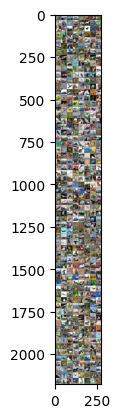

Labels: cat   ship  ship  airplane frog  frog  automobile frog  cat   automobile airplane truck dog   horse truck ship  dog   horse ship  frog  horse airplane deer  truck dog   bird  deer  airplane truck frog  frog  dog   deer  dog   truck bird  deer  automobile truck dog   deer  frog  dog   frog  airplane truck cat   truck horse frog  truck ship  airplane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat   frog  bird  automobile bird  cat   horse bird  frog  ship  ship  airplane bird  truck cat   cat   ship  ship  automobile automobile horse bird  dog   bird  horse ship  truck airplane cat   ship  frog  deer  frog  frog  airplane airplane horse deer  dog   frog  cat   automobile automobile cat   frog  ship  horse deer  airplane frog  bird  automobile cat   airplane deer  bird  horse ship  cat   automobile bird  ship  airplane ship  cat   dog   bird  deer  automobile ship  truck automobile bird  truck horse bird  truck frog  dog   frog  cat   ship  horse frog  bird  dog  

In [3]:
import matplotlib.pyplot as plt

def imshow(imgs, means, stds):
    # 确保 Tensor 在转换为 NumPy 前已经位于 CPU 上
    # 从 PyTorch [C, H, W] 转换为 NumPy [H, W, C]
    imgs = imgs.cpu().numpy().transpose((1, 2, 0))

    # Unnormalize the image
    imgs = imgs * np.array(stds)[None, None, :] + np.array(means)[None, None, :]
    imgs = np.clip(imgs, 0, 1)  # Clip values to be in the range [0, 1] to avoid display issues

    plt.imshow(imgs)
    plt.show()

def show_batch_images(dataloader, classes, batch_size, mean, std):
    # Get a batch of training data
    dataiter = iter(dataloader)
    images, labels = next(dataiter)  # use next() to fetch the next batch

    # Show images and labels
    imshow(torchvision.utils.make_grid(images), mean, std)
    # Display labels
    print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(min(len(labels), batch_size))))

# Assuming train_loader and classes have been defined
print("显示一些训练图像:")
show_batch_images(
    train_loader, 
    classes, 
    batch_size, 
    CIFAR_MEAN_TRAIN, 
    CIFAR_STD_TRAIN
)

print("显示一些测试图像:")
show_batch_images(
    test_loader, 
    classes, 
    batch_size, 
    CIFAR_MEAN_TEST, 
    CIFAR_STD_TEST
)

## 2.创建分类器

### (1) 分类器

In [4]:
from torch import nn
from torch.nn import functional as F
from torch.nn import init as init

# 计算模型 (在一个批次中) 的准确率
def accuracy(outputs, labels):
    # torch.max 返回两个张量: 最大值和最大值对应的索引 (即预测的类别索引)
    # outputs 的形状通常是 [batch_size, num_classes],
    # 对 dim=1 取最大值就可以得到每行 (每个样本) 的预测类别
    _, predictions = torch.max(outputs, dim=1)
    # 计算并返回准确率
    correct = torch.sum(predictions == labels).float()
    return correct / labels.size(0)

# 基本的分类模型的训练和测试功能
class BaseClassification(nn.Module):
    # 处理单个训练批次, 返回字典包含该批次的损失和准确率
    def step(self, batch, train=True):
        # batch 是从 DataLoader 中得到的一对 (images, labels)
        images, labels = batch
        # 前向传播: 调用子类实现的 forward 方法, 对 images 得到输出 logits
        outputs = self(images)
        # 计算交叉熵损失
        loss = F.cross_entropy(outputs, labels)
        # 计算准确率
        acc = accuracy(outputs, labels)
        if train:
            return {'train_loss': loss, 'train_acc': acc}
        else:
            # 使用loss.detach()取消跟踪梯度, 以减少内存消耗
            return {'test_loss': loss.detach(), 'test_acc': acc}

    # 计算整个测试周期内的平均损失和平均准确率
    def epoch(self, results):
        batch_losses = [x['test_loss'] for x in results]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in results]
        epoch_acc = sum(batch_accs) / len(batch_accs)
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

    # 输出训练周期结束时的结果, 包括学习率、训练损失、训练准确率、验证损失和验证准确率
    def summarize_epoch(self, epoch, result):
        print("Epoch [{}], learning_rate: {:.5f}, train_loss: {:.4f}, train_acc: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch,
            # result['lrs'] 是一个列表, 保存了每个迭代或每个 epoch 的学习率
            # 取最后一个元素, 表示当前 epoch 使用的学习率
            result['lrs'][-1],
            result['train_loss'],
            result['train_acc'],
            result['test_loss'],
            result['test_acc']
        ))

In [5]:
from thop import profile
from torchsummary import summary
import io
import contextlib

# 计算模型参数量的函数
def calc_param(model: nn.Module) -> int:
    # 将 model.parameters() 转换为 Python 列表, 包含所有可训练参数的 Tensor
    params = list(model.parameters())
    param_size = 0
    # 遍历每一个参数 Tensor
    for _param in params:
        _param_size = 1
        # 把该 Tensor 的所有维度大小相乘, 得到该 Tensor 总共有多少个标量元素
        for _dim in _param.size():
            _param_size *= _dim
        # 把当前参数的元素个数累加到总参数量
        param_size += _param_size
    # 返回所有可训练参数的总元素个数
    return param_size

def model_info(model, device):
    # 计算模型参数量
    print(f"模型参数量为: {calc_param(model)}")

    # 计算模型 FLOPs (浮点运算次数)
    # 创建一个 StringIO 对象来捕获输出
    buffer = io.StringIO()
    # 使用 redirect_stdout 将输出重定向到 buffer
    with contextlib.redirect_stdout(buffer):
        # 构造一个形状为 (1, 3, 32, 32) 的随机输入张量, 用于模拟一次前向传播
        # 这与 CIFAR-10 或类似小尺寸彩色图像的输入尺寸一致
        input = torch.randn(1, 3, 32, 32, device=device)
        # 调用 thop.profile, 计算给定模型在该输入下的 FLOPs 和参数量 (第二个返回值是 params，但我们这里不使用)
        flops, _ = profile(model, inputs=(input,))
    
    # 将 FLOPs 从“原始计数”转换为“十亿次浮点运算” (GFLOPs)
    gflops = flops / 1e9  # 将 FLOPs 转换为 GFLOPs
    print(f"FLOPs: {gflops:.3f} GFLOPs")

    # 计算模型所占空间大小
    # 创建一个 StringIO 对象来捕获输出
    buffer = io.StringIO()
    # 使用 redirect_stdout 将输出重定向到 buffer
    with contextlib.redirect_stdout(buffer):
      summary(model, (3, 32, 32))

    # 现在 buffer 包含了所有输出
    output = buffer.getvalue()
    # 关闭 buffer
    buffer.close()
    # 定义需要打印的行的开始标记
    keywords = [
        'Input size (MB)',
        'Forward/backward pass size (MB)',
        'Params size (MB)',
        'Estimated Total Size (MB)'
    ]
    # 遍历输出的每一行并打印包含关键字的行
    for line in output.split('\n'):
        # 如果该行包含我们关注的关键字之一, 就打印该行
        if any(keyword in line for keyword in keywords):
            print(line)

### (2) 卷积块

In [6]:
# 为处理 CIFAR10 数据集而设计的卷积块
class Basic_Block_0(BaseClassification):
    def __init__(self, in_channels, out_channels, kernel_size, num, act_func="relu", pool=False):
        '''
        in_channels: 输入通道数
        out_channels: 输出通道数
        kernel_size: 卷积核大小
        num: 要重复卷积层的次数
        act_func: 激活函数类型: "relu" / "sigmoid" / "tanh"
        pool: 是否在卷积后添加池化层
        '''
        # 调用父类 BaseClassification 的构造函数
        super(Basic_Block_0, self).__init__()
        
        # ===========================
        # 1. 全局平均池化层: AdaptiveAvgPool2d(1), 在全连接层之前减少空间维度
        #    将输入的特征图在 H×W 空间维度上做平均,
        #    最终输出的每个通道特征图变为 1×1 大小 (也就是每个通道只剩下一个数).
        #    常用于特征通道的全局特征提取, 为后续的通道注意力或通道加权做准备.
        #    输出 shape: 从 (batch_size, in_channels, H, W) -> (batch_size, in_channels, 1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # ===========================
        # 2. 全连接层 Linear1: nn.Linear(in_channels, num), 将平均池化后的特征映射到一个新的特征空间
        #    用于把全局平均池化得到的 in_channels 个通道的特征映射,
        #    投影到 num 维度上, 生成 num 个标量. 对应每个并行卷积分支要用的权重.
        #    输入形状: (batch_size, in_channels)
        #    输出形状: (batch_size, num)
        self.Linear1=nn.Linear(in_channels, num)

        # ===========================
        # 3. 根据 act_func 参数，选择对应的激活函数
        #    支持 "relu" / "sigmoid" / "tanh"，默认为 ReLU
        self.act = self._get_activation(act_func)
        
        # ===========================
        # 4. 并行卷积块列表 convs: 使用 nn.ModuleList 维护多个并行分支
        #    每个分支都由以下子层组成:
        #      - nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
        #          卷积操作: 从 in_channels -> out_channels，kernel_size 大小
        #          这里 padding=1 假设 kernel_size=3 时保持 H×W 不变.
        #      - nn.BatchNorm2d(out_channels)
        #          对卷积输出做批归一化, 加速收敛并稳定训练.
        #      - nn.ReLU() / nn.Sigmoid() / nn.Tanh()
        #          卷积后的激活函数.
        #      - 如果 pool=True, 则添加 nn.MaxPool2d(kernel_size=2), 否则添加 nn.Identity() (恒等层, 不改变输入)
        #          MaxPool2d(kernel_size=2) 将 H×W 缩减为 H/2×W/2; Identity 保持尺寸不变.
        #
        #    通过列表推导式, 将上述 Sequential 模块复制 num 次, 得到 num 个并行分支.
        #    该 ModuleList 会在 forward 时逐一调用每个 .convs[i] 进行并行计算.
        self.convs = nn.ModuleList([
            nn.Sequential(
                # 4.1 卷积层: in_channels -> out_channels, kernel_size, padding=1 保持 H×W
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
                # 4.2 批归一化
                nn.BatchNorm2d(out_channels),
                # 4.3 激活函数: 采用与 Linear1 后激活相同的类型
                self._get_activation(act_func)
            )
            for _ in range(num)
        ])
        # 统一池化层
        self.final_pool = nn.MaxPool2d(kernel_size=2) if pool else nn.Identity()

    def _get_activation(self, act_func):
        """
        返回卷积层中使用的激活函数实例，与 act_func 保持一致。
        由于要在 ModuleList 的构造中调用，所以单独封装成方法。
        """
        if act_func.lower() == "relu":
            return nn.ReLU(inplace=True)
        elif act_func.lower() == "sigmoid":
            return nn.Sigmoid()
        elif act_func.lower() == "tanh":
            return nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation function: {act_func}")

    # ===========================================
    # 前向传播方法
    def forward(self, x):
        """
        输入:
          x: Tensor, 形状 [batch_size, in_channels, H, W]
        输出:
          output: Tensor, 形状 [batch_size, out_channels, H_out, W_out]
                  其中 H_out, W_out 取决于卷积层和池化层是否存在.
        算法步骤:
          1. 对输入 x 做全局平均池化, 得到 (batch_size, in_channels, 1, 1)
          2. 将池化结果展平为 (batch_size, in_channels)
          3. 通过全连接层投影到 num 维度 -> (batch_size, num)
          4. 对该向量做激活, 得到 num 个通道加权系数
          5. 对每个并行卷积分支 i:
               - 用原始输入 x 通过卷积分支 self.convs[i], 得到 (batch_size, out_channels, H_i, W_i)
               - 取加权系数 a[:, i]，形状 (batch_size); 扩展到 (batch_size, 1, 1, 1)
               - 用 a[:, i] 乘以该分支的输出 -> (batch_size, out_channels, H_i, W_i)
          6. 把所有经加权后的分支输出逐元素相加 -> 最终 output
        """

        # ---------------------------
        # 1. 全局平均池化：
        #    x 的形状: [batch_size, in_channels, H, W]
        #    self.avgpool(x) -> [batch_size, in_channels, 1, 1]
        a=self.avgpool(x)

        # ---------------------------
        # 2. 把池化结果展平
        #    a.size(0) = batch_size
        #    a.view(a.size(0), -1) -> [batch_size, in_channels]
        a=a.view(a.size(0),-1)

        # ---------------------------
        # 3. 全连接层映射
        #    将 [batch_size, in_channels] -> [batch_size, num]
        a=self.Linear1((a))

        # ---------------------------
        # 4. 应用激活函数
        #    使输出向量中的每个元素都不小于 0
        #    形状依旧为 [batch_size, num]
        a=self.act(a)

        # ---------------------------
        # 5. 对每个并行卷积分支计算加权输出
        #    parallel_outputs 将保存 num 个张量, 每个张量形状为:
        #       [batch_size, out_channels, H_i, W_i]
        #    其中 H_i, W_i 如果有池化层则会是 H/2, W/2, 否则依旧是 H, W.
        parallel_outputs = []
        # 遍历 num 个分支
        for i in range(a.size(1)):  # a.size(1) == num
            # 5.1. 取出第 i 个分支的加权系数向量 a[:, i]
            #      形状: [batch_size]，先用 .view(-1, 1, 1, 1) 把它扩展到
            #      [batch_size, 1, 1, 1], 以便后面广播乘法.
            weight_i = a[:, i].view(-1, 1, 1, 1)

            # 5.2. 用第 i 个卷积分支 self.convs[i] 处理原始输入 x:
            #      self.convs[i](x) -> [batch_size, out_channels, H_i, W_i]
            conv_out_i = self.convs[i](x)

            # 5.3. 用 weight_i 去调制 conv_out_i, 每个样本的通道整张特征图都乘以对应标量
            #      结果张量形状仍为 [batch_size, out_channels, H_i, W_i]
            weighted_out_i = weight_i * conv_out_i

            # 将当前分支加权后的输出添加到列表
            parallel_outputs.append(weighted_out_i)

        # ---------------------------
        # 6. 将所有分支的加权输出逐元素相加, 得到最终输出
        #    sum(parallel_outputs) 等价于逐元素相加 [batch_size, out_channels, H_out, W_out]
        output = sum(parallel_outputs)
        output = self.final_pool(output)
        return output

In [7]:
# 为处理 CIFAR10 数据集而设计的卷积块
class Basic_Block_1(BaseClassification):
    def __init__(self, in_channels, out_channels, kernel_size, num, act_func="relu", pool=False, reduction=16):
        '''
        in_channels: 输入通道数
        out_channels: 输出通道数
        kernel_size: 卷积核大小
        num: 要重复卷积层的次数
        act_func: 激活函数类型: "relu" / "sigmoid" / "tanh"
        pool: 是否在卷积后添加池化层
        reduction (int): SE 模块中的通道压缩比，常设 16
        '''
        # 调用父类 BaseClassification 的构造函数
        super(Basic_Block_1, self).__init__()
    
        # ===========================
        # 1. 根据 act_func 参数，选择对应的激活函数
        #    支持 "relu" / "sigmoid" / "tanh"，默认为 ReLU
        self.act = self._get_activation(act_func)

        # ----------------------------
        # 2. 构建主体卷积序列 (Conv -> BN -> Act), 堆叠 num 层
        layers = []
        for i in range(num):
            # 对第一个卷积, 使用 pool 决定是否做下采样 (stride=2); 后续卷积 stride=1
            stride = 2 if (i == 0 and pool) else 1
            in_c = in_channels if i == 0 else out_channels
            layers.append(nn.Conv2d(in_c, out_channels, kernel_size, stride=stride, padding=kernel_size//2, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            # 每层卷积后都使用相同类型的激活
            layers.append(self._get_activation(act_func))
        self.conv_sequence = nn.Sequential(*layers)

        # ----------------------------
        # 3. 如果需要下采样或通道对齐，则定义一个 downsample 分支 (1×1 Conv + BN)
        self.need_downsample = pool or (in_channels != out_channels)
        if self.need_downsample:
            ds_stride = 2 if pool else 1
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=ds_stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = nn.Identity()

        # ----------------------------
        # 4. Squeeze-and-Excitation 模块
        #    GAP -> FC (out_channels/reduction) -> Act (ReLU) -> FC (out_channels) -> Sigmoid
        #    最终输出与输入特征图逐通道相乘
        se_hidden = max(out_channels // reduction, 1)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),               # [B, out_channels, 1, 1]
            nn.Conv2d(out_channels, se_hidden, 1), # [B, out_hidden, 1, 1]
            nn.ReLU(inplace=True),
            nn.Conv2d(se_hidden, out_channels, 1), # [B, out_channels, 1, 1]
            nn.Sigmoid()                           # [B, out_channels, 1, 1]
        )

    def _get_activation(self, act_func):
        """
        返回卷积层中使用的激活函数实例，与 act_func 保持一致。
        由于要在 ModuleList 的构造中调用，所以单独封装成方法。
        """
        if act_func.lower() == "relu":
            return nn.ReLU(inplace=True)
        elif act_func.lower() == "sigmoid":
            return nn.Sigmoid()
        elif act_func.lower() == "tanh":
            return nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation function: {act_func}")

    # ===========================================
    # 前向传播方法
    def forward(self, x):
        """
        前向传播:
          1. x 可能先经过 downsample (如果 in_channels != out_channels 或 pool=True)
          2. conv_sequence 对 x 进行多层卷积->BN->激活 (第一层可能做 stride=2 下采样)
          3. 将 conv_sequence 的输出与 identity 相加，形成残差输出
          4. 对相加结果应用 SE 模块，做通道注意力加权
          5. 最后再经过一次激活函数
        """
        # 1. 保存恒等分支
        identity = x
        if self.need_downsample:
            identity = self.downsample(x)

        # 2. 主干序列卷积
        out = self.conv_sequence(x)
        # out 形状可能是 [B, out_channels, H/2, W/2] (如果下采样)，或 [B, out_channels, H, W]

        # 3. 残差相加
        out = out + identity

        # 4. SE 注意力: 先做 GAP -> FC -> ReLU -> FC -> Sigmoid -> 缩放通道
        se_weight = self.se(out)        # 形状 [B, out_channels, 1, 1]
        out = out * se_weight           # 通道级别加权
        return out

### (3) Model No.0

In [8]:
class CNN_model_0(BaseClassification):
    def __init__(self, act_func):
        '''
        CIFAR_Block(in_channels, out_channels, kernel_size, num, pool)
          in_channels: 输入通道数
          out_channels: 输出通道数
          kernel_size: 卷积核大小
          num: 要重复卷积层的次数
          pool: 是否在卷积后添加池化层
        '''
        super(CNN_model_0, self).__init__()
        # CIFAR_Block卷积块
        self.block1 = Basic_Block_0(3,  20, 3, 7, act_func=act_func, pool=False)
        self.block2 = Basic_Block_0(20, 32, 3, 7, act_func=act_func, pool=True)
        self.block3 = Basic_Block_0(32, 32, 3, 7, act_func=act_func, pool=True)
        self.block4 = Basic_Block_0(32, 64, 3, 7, act_func=act_func, pool=False)
        # 自适应平均池化层: 将特征图 [B, 128, H, W] 池化到 [B, 128, 1, 1]
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        # 全连接层
        self.fc1=nn.Linear(64, 128)
        # 激活函数
        self.act=self._get_activation(act_func)
        # 正则化, 随机丢弃一些激活值
        self.drop=nn.Dropout(0.5)
        # 全连接层
        self.fc2=nn.Linear(128,10)

        # ====================================
        # 4. 权重初始化：根据 act_func 选择合适的初始化方法
        self._initialize_weights(act_func)

    def _get_activation(self, act_func):
        """
        返回卷积层中使用的激活函数实例，与 act_func 保持一致。
        由于要在 ModuleList 的构造中调用，所以单独封装成方法。
        """
        if act_func.lower() == "relu":
            return nn.ReLU(inplace=True)
        elif act_func.lower() == "sigmoid":
            return nn.Sigmoid()
        elif act_func.lower() == "tanh":
            return nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation function: {act_func}")

    def _initialize_weights(self, act_func):
        """
        对模型中所有可训练层 (Conv2d、Linear、BatchNorm) 进行初始化.
        - 若 act_func == "relu", 则对 Conv/Linear 使用 Kaiming Normal 初始化 (He 初始化).
        - 若 act_func == "sigmoid" 或 "tanh", 则对 Conv/Linear 使用 Xavier (Glorot) 初始化.
        - BatchNorm 的权重初始化为 1, 偏置初始化为 0.
        """
        for m in self.modules():
            # 卷积层
            if isinstance(m, nn.Conv2d):
                if act_func.lower() == "relu":
                    # Kaiming 正态初始化, 适用于 ReLU
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                else:
                    # Xavier 均匀初始化, 适用于 Sigmoid 和 Tanh
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            
            # 全连接层
            elif isinstance(m, nn.Linear):
                if act_func.lower() == "relu":
                    # Kaiming 正态初始化
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                else:
                    # Xavier 均匀初始化
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            
            # BatchNorm 层
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                # 将所有 BatchNorm 的 scale 设置为 1, 偏置设置为 0
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    # 前向传播方法
    def forward(self, x):
        # 依次通过这六个卷积块进行特征提取
        output=self.block1(x)
        output=self.block2(output)
        output=self.block3(output)
        output=self.block4(output)
        # 通过自适应平均池化层, 将每个特征图简化为一个单一的数值
        output=self.avgpool(output)
        # 将平坦化后的特征输入第一个全连接层
        output=self.fc1(output.view(output.size(0),-1))
        # 通过激活、dropout处理, 最后通过第二个全连接层得到最终的分类结果
        output=self.act(output)
        output=self.drop(output)
        output=self.fc2(output)
        return output

act_func = "relu"
model_0 = to_device(CNN_model_0(act_func), device)
# print(model_0)

# 输出模型的参数量、FLOPs、所占空间大小
model_info(model_0, device)

模型参数量为: 250991
FLOPs: 0.072 GFLOPs
Input size (MB): 0.01
Forward/backward pass size (MB): 11.04
Params size (MB): 0.96
Estimated Total Size (MB): 12.01


### (4) Model No.1

In [9]:
class CNN_model_1(BaseClassification):
    def __init__(self, act_func):
        '''
        CIFAR_Block(in_channels, out_channels, kernel_size, num, pool)
          in_channels: 输入通道数
          out_channels: 输出通道数
          kernel_size: 卷积核大小
          num: 要重复卷积层的次数
          pool: 是否在卷积后添加池化层
        '''
        super(CNN_model_1, self).__init__()
        self.in_channels = 16  # 初始通道数
        self.act_func = act_func

        # 初始卷积: 输入为3通道，输出为16通道
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.in_channels),
            self._get_activation(act_func)
        )

        # Stage 1: 输出通道数不变, 重复 7 个 block, 不下采样
        self.stage1 = self._make_stage(out_channels=16, num_blocks=7, pool_first=False)

        # Stage 2: 输出通道变为 32, 重复 7 个 block, 首个 block 下采样
        self.stage2 = self._make_stage(out_channels=32, num_blocks=7, pool_first=True)

        # Stage 3: 输出通道变为 64, 重复 7 个 block, 首个 block 下采样
        self.stage3 = self._make_stage(out_channels=64, num_blocks=7, pool_first=True)

        # 自适应平均池化层: 将特征图 [B, 128, H, W] 池化到 [B, 128, 1, 1]
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        # 全连接层
        self.fc1=nn.Linear(64,128)
        # 激活函数
        self.act=self._get_activation(act_func)
        # 正则化, 随机丢弃一些激活值
        self.drop=nn.Dropout(0.5)
        # 全连接层
        self.fc2=nn.Linear(128,10)

        # ====================================
        # 4. 权重初始化：根据 act_func 选择合适的初始化方法
        self._initialize_weights(act_func)

    def _make_stage(self, out_channels, num_blocks, pool_first):
        """
        构建一个 stage, 由多个 Basic_Block_1 组成。
        - out_channels: 所有 block 的输出通道
        - num_blocks: block 的个数
        - pool_first: 是否第一个 block 做下采样
        """
        layers = []
        for i in range(num_blocks):
            pool = (i == 0 and pool_first)
            block = Basic_Block_1(
                in_channels=self.in_channels,
                out_channels=out_channels,
                kernel_size=3,
                num=2,  # 每个 block 有 2 层 conv
                act_func=self.act_func,
                pool=pool
            )
            layers.append(block)
            self.in_channels = out_channels  # 下一层的输入通道对齐
        return nn.Sequential(*layers)

    def _get_activation(self, act_func):
        """
        返回卷积层中使用的激活函数实例，与 act_func 保持一致。
        由于要在 ModuleList 的构造中调用，所以单独封装成方法。
        """
        if act_func.lower() == "relu":
            return nn.ReLU(inplace=True)
        elif act_func.lower() == "sigmoid":
            return nn.Sigmoid()
        elif act_func.lower() == "tanh":
            return nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation function: {act_func}")

    def _initialize_weights(self, act_func):
        """
        对模型中所有可训练层 (Conv2d、Linear、BatchNorm) 进行初始化.
        - 若 act_func == "relu", 则对 Conv/Linear 使用 Kaiming Normal 初始化 (He 初始化).
        - 若 act_func == "sigmoid" 或 "tanh", 则对 Conv/Linear 使用 Xavier (Glorot) 初始化.
        - BatchNorm 的权重初始化为 1, 偏置初始化为 0.
        """
        for m in self.modules():
            # 卷积层
            if isinstance(m, nn.Conv2d):
                if act_func.lower() == "relu":
                    # Kaiming 正态初始化, 适用于 ReLU
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                else:
                    # Xavier 均匀初始化, 适用于 Sigmoid 和 Tanh
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            
            # 全连接层
            elif isinstance(m, nn.Linear):
                if act_func.lower() == "relu":
                    # Kaiming 正态初始化
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                else:
                    # Xavier 均匀初始化
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            
            # BatchNorm 层
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                # 将所有 BatchNorm 的 scale 设置为 1，偏置设置为 0
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    # 前向传播方法
    def forward(self, x):
        # 依次通过这六个卷积块进行特征提取
        output=self.stem(x)
        output=self.stage1(output)
        output=self.stage2(output)
        output=self.stage3(output)
        # 通过自适应平均池化层, 将每个特征图简化为一个单一的数值
        output=self.avgpool(output)
        # 将平坦化后的特征输入第一个全连接层
        output=self.fc1(output.view(output.size(0),-1))
        # 通过激活、dropout处理, 最后通过第二个全连接层得到最终的分类结果
        output=self.act(output)
        output=self.drop(output)
        output=self.fc2(output)
        return output

act_func = "relu"
model_1 = to_device(CNN_model_1(act_func), device)
# print(model_1)

# 输出模型的参数量、FLOPs、所占空间大小
model_info(model_1, device)

模型参数量为: 675835
FLOPs: 0.099 GFLOPs
Input size (MB): 0.01
Forward/backward pass size (MB): 11.30
Params size (MB): 2.58
Estimated Total Size (MB): 13.89


## 3.训练分类器

### (1) 提前终止策略

In [10]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        """
        patience: 评估提前停止的周期数
        min_delta: 认为性能提升是显著的最小变化
        """
        # 保存用户设定的 patience 和 min_delta
        self.patience = patience
        self.min_delta = min_delta
        # best_acc 保存目前为止观察到的最高验证准确率
        self.best_acc = float('-inf')
        # wait 记录经过多少个 epoch 验证损失没有显著改善
        self.wait = 0
        # stopped_epoch 记录提前停止触发时的 epoch 编号
        self.stopped_epoch = 0
        # best_acc_changed 标记刚刚这个 epoch 是否更新了 best_acc
        self.best_acc_changed = False
        # early_stop 标记是否已经触发提前停止
        self.early_stop = False

    def __call__(self, test_acc, test_loss, epoch, patience):
        # 比较当前准确率和历史最小准确率, 看是否有至少 min_delta 的上升
        # print(test_acc - self.best_acc) # debug
        if test_acc - self.best_acc > self.min_delta:
            # 1. 验证准确率显著下降
            self.best_acc = test_acc   # 更新最优验证准确率
            self.best_loss = test_loss # 更新最优验证损失
            self.wait = 0              # 重置等待计数
            self.best_acc_changed = True
        else:
            # 2. 没有显著下降, 则将等待计数加 1
            self.wait += 1
            self.best_acc_changed = False
            # 如果超过或等于 patience, 则触发提前停止
            if self.wait >= self.patience:
                self.early_stop = True
                self.stopped_epoch = epoch
                print(
                    f"Early stopping triggered after epoch {self.stopped_epoch}\n"
                    + f"Best accuracy {self.best_acc} occurred at epoch {self.stopped_epoch - patience}"
                )

### (2) 定义执行训练周期的函数

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import math

# 告诉PyTorch在执行evaluate函数时不需要计算梯度
@torch.no_grad()
def evaluate(model, test_loader):
    # 将模型设置为评估模式, BatchNorm/Dropout 等层将工作在推理状态
    model.eval()
    # 计算每个批次的损失和准确率
    device = next(model.parameters()).device
    outputs = []
    for batch in test_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        outputs.append(model.step((images, labels), train=False))
    # 计算并返回整个测试周期的平均损失和平均准确率
    return model.epoch(outputs)

# 从优化器中提取当前的学习率 (以第一个参数为准)
def get_learning_rate(optimizer, param_index=0):
    return optimizer.param_groups[0]['lr']

# 线性 Warmup
def warmup_lambda(epoch, warmup_epochs, total_epochs, min_lr_ratio=0.1):
    if epoch < warmup_epochs:
        return float(epoch + 1) / warmup_epochs
    elif epoch < warmup_epochs * 3:
        return 1.0
    else:
        # 余弦退火
        cosine_epoch = epoch - warmup_epochs * 3
        cosine_total = total_epochs - warmup_epochs * 3
        cosine_decay = 0.5 * (1 + math.cos(math.pi * cosine_epoch / cosine_total))
        return min_lr_ratio + (1 - min_lr_ratio) * cosine_decay
    
# 使用 “Warmup + Adam” 学习率调度策略的训练循环
def fit_with_warmup_adam(
    epochs,
    max_lr,
    model,
    train_loader,
    test_loader,
    weight_decay=1e-4,
    grad_clip=None,
    beta1=0.9,
    beta2=0.999,
    eps=1e-6,
    warmup_epochs=5,
    best_model_path="./best_model.pth",
    patience=10,
    min_delta=0.001
):
    """
    训练模型：使用 Adam 优化器（自带每参数自适应学习率）+ 前 warmup_epochs 线性预热 + EarlyStopping。
    在 warmup 结束后, Adam 会凭借其内部一阶/二阶矩估计自动调节每个参数的实际更新步长。
    
    参数:
        epochs (int):           总的训练 epoch 数
        max_lr (float):         预热结束后的最大学习率，也是 Adam 的初始学习率
        model (nn.Module):      待训练的网络，继承 BaseClassification
        train_loader:           训练集 DataLoader
        test_loader:            测试集 DataLoader
        weight_decay (float):   L2 正则化系数 (默认 0)
        grad_clip (float|None): 梯度裁剪阈值 (None 表示不裁剪)
        beta1 (float):          Adam 的 β₁ 参数 (一阶矩衰减率)
        beta2 (float):          Adam 的 β₂ 参数 (二阶矩衰减率)
        eps (float):            Adam 的 ε 参数 (数值稳定项)
        warmup_epochs (int):    前 warmup 阶段的 epoch 数 (线性升到 max_lr)
        best_model_path (str):  保存最优模型的路径
        patience (int):         EarlyStopping 的耐心值
        min_delta (float):      EarlyStopping 判定“显著改善”的最小准确率差值
    
    返回:
        history (list of dict): 每个 epoch 结束后记录的结果列表，
                                每个元素包含 {'train_loss','train_acc','test_loss','test_acc','lrs'}
    """
    # 释放不再使用的显存
    torch.cuda.empty_cache()
    # 用来存储每个训练周期的结果
    history = []

    # ------------------------------
    # 1. 初始化优化器 (Adam)：
    #    在 warmup 期间，我们会把 lr 从 0 线性升到 max_lr
    optimizer = optim.Adam(
        model.parameters(),
        lr=max_lr,
        betas=(beta1, beta2),
        eps=eps,
        weight_decay=weight_decay
    )

    # 2. 用 LambdaLR 实现 warmup
    scheduler = LambdaLR(
        optimizer,
        lr_lambda=lambda epoch: warmup_lambda(epoch, warmup_epochs, epochs)
    )

    # 3. 初始化 EarlyStopping
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

    # ------------------------------
    # 4. 训练循环
    for epoch in range(1, epochs + 1):
        # 切换到训练模式 (启用 Dropout, BatchNorm 更新均值/方差)
        model.train()
        train_losses = []
        train_accs = []
        lrs = []

        # ------------------------------
        # 4.1 遍历所有训练批次
        for batch in train_loader:
            # batch = (images, labels)
            images, labels = batch
            images = images.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)

            # 前向 + loss + acc
            result = model.step((images, labels), train=True)
            loss = result['train_loss']        # Tensor 形式
            acc  = result['train_acc']         # Tensor 形式

            # 反向传播
            optimizer.zero_grad()
            loss.backward()

            # 可选梯度裁剪 (只在 warmup 完成后裁剪)
            if grad_clip is not None and epoch > warmup_epochs:
                total_norm = nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                # print(f"Grad norm before clipping: {total_norm:.4f}") # debug

            # 优化器更新参数
            optimizer.step()
            optimizer.zero_grad()

            # 记录训练指标
            train_losses.append(loss.detach())
            train_accs.append(acc)

            # 记录当前 "名义学习率"
            current_lr = get_learning_rate(optimizer)
            if not lrs:
                lrs.append(current_lr)

        # 4.2 更新学习率调度器 (按 epoch 更新)
        scheduler.step()

        # ------------------------------
        # 4.3 在测试集上进行评估 (evaluate 已自动关闭梯度)
        result = evaluate(model, test_loader)
        # 将训练集指标也合并到 result 中
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc']  = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs

        # 打印本 epoch 的完整信息: lr, train_loss, train_acc, test_loss, test_acc
        model.summarize_epoch(epoch, result)

        # ------------------------------
        # 4.4 EarlyStopping 逻辑: 
        # 如果测试准确率连续多次没有显著下降, 就提前停止
        early_stopping(result['test_acc'], result['test_loss'], epoch, patience)
        # 如果当前 epoch 使得 best_acc 更新了, 就保存最优模型
        if early_stopping.best_acc_changed:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'test_acc': early_stopping.best_acc,
                'test_loss': early_stopping.best_loss
            }, best_model_path)
            print(
                f"New best model saved at epoch {epoch} with accuracy {early_stopping.best_acc:.4f}"
            )

        # ------------------------------
        # 将本 epoch 结果追加到 history，方便后续可视化或分析
        history.append(result)

        # 如果触发了提前停止, 则结束训练
        if early_stopping.early_stop:
            print("Early stopping——training halted.\n")
            break

    return history

### (3) 训练 Model No.0

In [12]:
# 计算并输出初始模型(未训练前)的性能
history_0 = [evaluate(model_0, test_loader)]
print(history_0)

# 设置超参数
epochs = 100
warmup_epochs = 5
max_lr = 0.0005
grad_clip = 1
weight_decay = 1e-5
# 提前停止策略的参数
patience = 10
min_delta = 0.001
# 最优模型的保存路径
best_model_path_0 = "./saved_weights/best_results_1/best_model_0.pth"

# 检查目录是否存在, 如果不存在, 则创建
if not os.path.exists(os.path.dirname(best_model_path_0)):
    os.makedirs(os.path.dirname(best_model_path_0))

# 进行训练
history_0 += fit_with_warmup_adam(
    epochs, max_lr, model_0, train_loader, test_loader,
    weight_decay=weight_decay,
    grad_clip=grad_clip,
    warmup_epochs=warmup_epochs,
    best_model_path=best_model_path_0,
    patience=patience,
    min_delta=min_delta
)

[{'test_loss': 153701.796875, 'test_acc': 0.1124482974410057}]
Epoch [1], learning_rate: 0.00010, train_loss: 27.8284, train_acc: 0.1035, test_loss: 2.4218, test_acc: 0.0869
New best model saved at epoch 1 with accuracy 0.0869
Epoch [2], learning_rate: 0.00020, train_loss: 2.3709, train_acc: 0.1102, test_loss: 2.2916, test_acc: 0.1286
New best model saved at epoch 2 with accuracy 0.1286
Epoch [3], learning_rate: 0.00030, train_loss: 2.2999, train_acc: 0.1271, test_loss: 2.2635, test_acc: 0.1487
New best model saved at epoch 3 with accuracy 0.1487
Epoch [4], learning_rate: 0.00040, train_loss: 2.2622, train_acc: 0.1464, test_loss: 2.2032, test_acc: 0.1877
New best model saved at epoch 4 with accuracy 0.1877
Epoch [5], learning_rate: 0.00050, train_loss: 2.2169, train_acc: 0.1637, test_loss: 2.1532, test_acc: 0.2046
New best model saved at epoch 5 with accuracy 0.2046
Epoch [6], learning_rate: 0.00050, train_loss: 2.1729, train_acc: 0.1769, test_loss: 2.1085, test_acc: 0.2243
New best mo

### (4) 训练 Model No.1

In [13]:
# 计算并输出初始模型(未训练前)的性能
history_1 = [evaluate(model_1, test_loader)]
print(history_1)

# 设置超参数
epochs = 100
max_lr = 0.001
warmup_epochs = 10
grad_clip = 1
weight_decay = 1e-4
# 提前停止策略的参数
patience = 10
min_delta = 0.001
# 最优模型的保存路径
best_model_path_1 = "./saved_weights/best_results_1/best_model_1.pth"

# 检查目录是否存在，如果不存在，则创建
if not os.path.exists(os.path.dirname(best_model_path_1)):
    os.makedirs(os.path.dirname(best_model_path_1))

# 进行训练
history_1 += fit_with_warmup_adam(
    epochs, max_lr, model_1, train_loader, test_loader,
    weight_decay=weight_decay,
    grad_clip=grad_clip,
    warmup_epochs=warmup_epochs,
    best_model_path=best_model_path_1,
    patience = patience,
    min_delta=min_delta
)

[{'test_loss': 2.3031601905822754, 'test_acc': 0.10032743215560913}]
Epoch [1], learning_rate: 0.00010, train_loss: 2.2719, train_acc: 0.1409, test_loss: 2.0034, test_acc: 0.2504
New best model saved at epoch 1 with accuracy 0.2504
Epoch [2], learning_rate: 0.00020, train_loss: 1.8540, train_acc: 0.2980, test_loss: 1.5972, test_acc: 0.4041
New best model saved at epoch 2 with accuracy 0.4041
Epoch [3], learning_rate: 0.00030, train_loss: 1.5797, train_acc: 0.4268, test_loss: 1.3621, test_acc: 0.5046
New best model saved at epoch 3 with accuracy 0.5046
Epoch [4], learning_rate: 0.00040, train_loss: 1.3802, train_acc: 0.5078, test_loss: 1.2268, test_acc: 0.5572
New best model saved at epoch 4 with accuracy 0.5572
Epoch [5], learning_rate: 0.00050, train_loss: 1.2182, train_acc: 0.5701, test_loss: 1.0860, test_acc: 0.6156
New best model saved at epoch 5 with accuracy 0.6156
Epoch [6], learning_rate: 0.00060, train_loss: 1.0747, train_acc: 0.6254, test_loss: 1.0656, test_acc: 0.6285
New be

## 4.模型性能

### (1) 准确率

In [14]:
import matplotlib.pyplot as plt

# 绘制准确率曲线
def plot_accuracies(history):
    test_accuracies = [x['test_acc'] for x in history]
    train_accuracies = [x.get('train_acc') for x in history]
    plt.plot(train_accuracies, '-b')
    plt.plot(test_accuracies, '-r')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Train', 'Test'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

# 绘制对数损失曲线
def plot_log_loss(history):
    # 从历史记录中获取损失数据
    test_loss = [x['test_loss'] for x in history]
    train_loss = [x.get('train_loss') for x in history]
    train_loss[0] = 1
    # 计算损失的自然对数, 注意防止对非正数取对数
    
    log_train_loss = np.log(train_loss)
    log_test_loss = np.log(test_loss)
    # 绘制自然对数损失曲线
    plt.plot(log_train_loss, '-b')
    plt.plot(log_test_loss, '-r')
    plt.xlabel('epoch')
    plt.ylabel('log loss')
    plt.legend(['Train', 'Test'])
    plt.title('Log Loss vs. No. of epochs')
    plt.show()

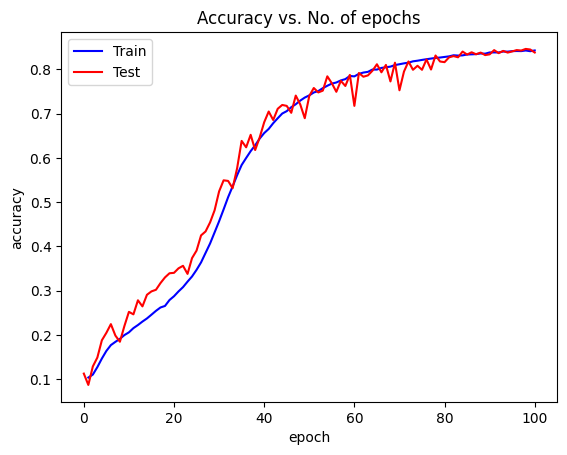

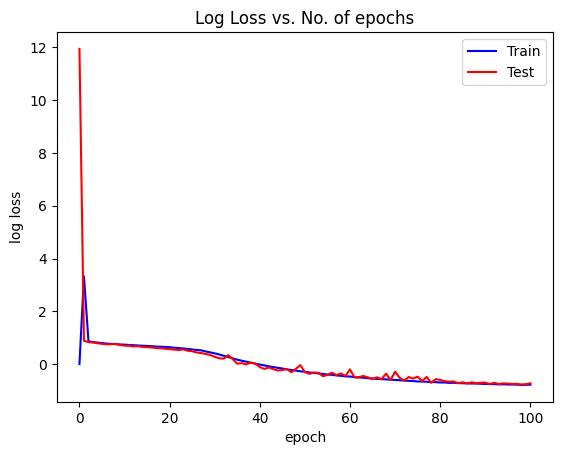

In [15]:
# 绘制 history_0
plot_accuracies(history_0)
plot_log_loss(history_0)

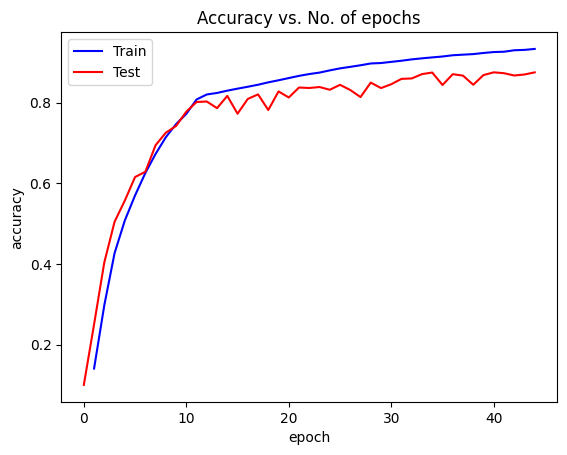

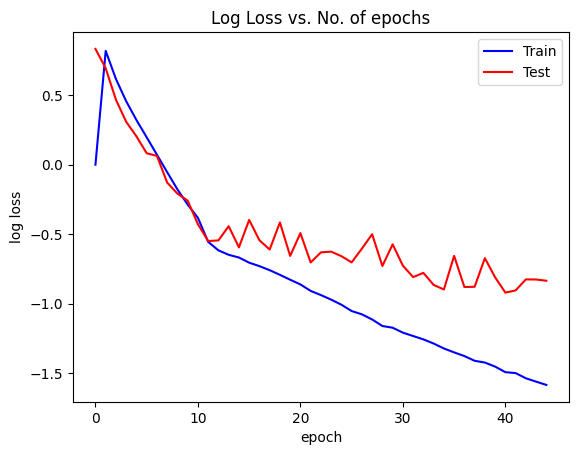

In [16]:
# 绘制 history_1
plot_accuracies(history_1)
plot_log_loss(history_1)

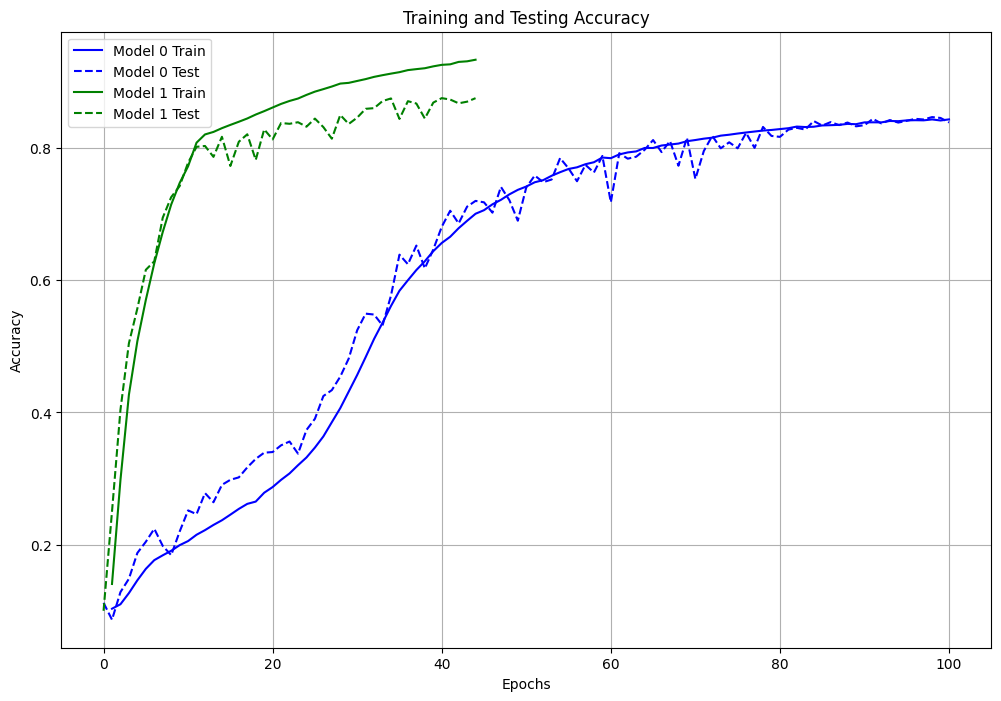

In [17]:
# Accuracy comparison of different models on CIFAR-10
# Data for model 0
test_acc_0 = [x['test_acc'] for x in history_0]
train_acc_0 = [x.get('train_acc') for x in history_0]

# Data for model 1
test_acc_1 = [x['test_acc'] for x in history_1]
train_acc_1 = [x.get('train_acc') for x in history_1]

# Plotting
plt.figure(figsize=(12, 8))

# Model 0
plt.plot(train_acc_0, label='Model 0 Train', color='blue', linestyle='-')
plt.plot(test_acc_0, label='Model 0 Test', color='blue', linestyle='--')

# Model 1
plt.plot(train_acc_1, label='Model 1 Train', color='green', linestyle='-')
plt.plot(test_acc_1, label='Model 1 Test', color='green', linestyle='--')

plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### (2) 比较学习率变化

In [18]:
lr = np.concatenate([x.get('lrs', [])[0] for x in history_0])
plt.plot(lr, '-b')
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.title('Learning Rate vs. No. of epochs')

IndexError: list index out of range

### (3) 加载最优模型 & 计算精确率

In [ ]:
# 数据集类别
classes = train_set.classes
print(classes)

# 计算每一批次中模型在某一类别上的精确率
def precision_per_class(outputs, labels, class_index):
    _, predictions = torch.max(outputs, dim=1)
    true_positives = torch.sum((predictions == class_index) & (labels == class_index)).item()
    predicted_positives = torch.sum(predictions == class_index).item()
    return {'true_positives': true_positives, 'predicted_positives': predicted_positives}

def average_precision(model, test_loader, classes):
    num_classes = len(classes)
    precision_values = []
    # 初始化列表来存储每个类的真正例数、预测正例数
    class_true_positives = [0] * num_classes
    class_predicted_positives = [0] * num_classes

    # 遍历测试数据
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            outputs = model(images)
            for i in range(num_classes):
                result = precision_per_class(outputs, labels, i)
                class_true_positives[i] += result['true_positives']
                class_predicted_positives[i] += result['predicted_positives']

    # 计算每个类的平均精确率，并且取总的平均
    for i in range(num_classes):
        if class_predicted_positives[i] > 0:
            precision = class_true_positives[i] / class_predicted_positives[i]
            precision_values.append(precision)
            print("Precision of class {}: \t{:.4f}".format(classes[i], precision))
        else: # handle the case where class_predicted_positives[i] == 0
            print("Precision of class {}: \tN/A (no predicted positives)".format(classes[i]))

    # 计算所有类的平均精确率
    avg_precision_value = sum(precision_values) / len(precision_values)
    print("The Average precision value is {:.4f}\n".format(avg_precision_value))

In [ ]:
# 恢复模型状态
checkpoint = torch.load(best_model_path_0)
model_0.load_state_dict(checkpoint['model_state_dict'])

# 计算精确率
average_precision(model_0, test_loader, classes)

In [ ]:
# 恢复模型状态
checkpoint = torch.load(best_model_path_1)
model_1.load_state_dict(checkpoint['model_state_dict'])

# 计算精确率
average_precision(model_1, test_loader, classes)